### Exercise 3
# Word Representations
Training a Word Embedder using Tokenizers and Autoencoder Architectures

#### Selecting a Dataset

Find a good dataset in any language you like. It does not have to be English, any language you understand well or know well enough to judge a model will work. 

We will be exploring different Word Embeddings and Tokenizers. 
Here are some resources for datasets to use for Tokenization:
- [Kaggle Datasets](https://www.kaggle.com/datasets)

- [Hugging Face Datasets](https://huggingface.co/datasets)

- [The Leipzig Corpora Collection](https://wortschatz.uni-leipzig.de/en/download)

- [The Natural Tokenization Processing](https://www.nltk.org/nltk_data)

- [Common Crawl](https://commoncrawl.org)

#### Import Libraries

In [ ]:
!pip install numpy pandas matplotlib scikit-learn torch nltk spacy sentencepiece tokenizers

In [ ]:
import matplotlib.pyplot as plt

# For tokenization
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

# For building the model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### Load and Preprocess the Dataset. 
Choose a dataset in your preferred language. For this example, we’ll use a small English corpus.

In [2]:
# Load your dataset
# For example, read from a text file
with open('datasets/eng_news_2023_10K-sentences.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Basic preprocessing with regular expressions (lowercasing, removing special characters)
import re
text = text.lower()
text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
nltk.data.path.append('/Users/arthurnuernberg/nltk_data')

# Tokenization
tokens = word_tokenize(text)
print(f'Total tokens: {len(tokens)}')
print(tokens[:10])

Total tokens: 197268
['1', 'must', 'be', 'staked', 'on', 'willie', 'mullins', 'to', 'have', 'a']


#### Build Vocabulary

In [3]:
# Set of unique tokens out of all tokens
vocab = set(tokens)
word_to_index = {word: index for index, word in enumerate(vocab)}
index_to_word = {index: word for word, index in word_to_index.items()}

vocab_size = len(vocab)
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 25113


#### Prepare Data for Autoencoder

In [6]:
# Convert tokens to indices
token_indices = [word_to_index[word] for word in tokens]

# Create input and target sequences
sequence_length = 5
input_sequences = []
target_words = []

for i in range(len(token_indices) - sequence_length):
    input_sequences.append(token_indices[i:i+sequence_length])
    target_words.append(token_indices[i+sequence_length])

print(f'Number of sequences: {len(input_sequences)}')

Number of sequences: 197263


#### Create a Custom Dataset

In [7]:
class TextDataset(Dataset):
    def __init__(self, input_sequences, target_words):
        self.inputs = input_sequences
        self.targets = target_words

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return (torch.tensor(self.inputs[idx], dtype=torch.long),
                torch.tensor(self.targets[idx], dtype=torch.long))

dataset = TextDataset(input_sequences, target_words)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

#### Define the Autoencoder Model

In [8]:
class WordEmbeddingAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(WordEmbeddingAutoencoder, self).__init__()
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.decoder = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        embedded = self.encoder(x)
        # Sum embeddings to get a fixed-size vector
        hidden = embedded.sum(dim=1)
        output = self.decoder(hidden)
        return output

embedding_dim = 100
model = WordEmbeddingAutoencoder(vocab_size, embedding_dim)
print(model)

WordEmbeddingAutoencoder(
  (encoder): Embedding(25113, 100)
  (decoder): Linear(in_features=100, out_features=25113, bias=True)
)


#### Define Loss Function and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Train the Model

In [11]:
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}')

Epoch 1/10, Loss: 6.746920185200471
Epoch 2/10, Loss: 5.945852245791098
Epoch 3/10, Loss: 5.405780831521647
Epoch 4/10, Loss: 5.020182880843339
Epoch 5/10, Loss: 4.727816231870203
Epoch 6/10, Loss: 4.487015280134292
Epoch 7/10, Loss: 4.27412769093051
Epoch 8/10, Loss: 4.079983879133281
Epoch 9/10, Loss: 3.901890367723849
Epoch 10/10, Loss: 3.7330808756299656


#### Extract Word Embeddings

In [13]:
embeddings = model.encoder.weight.data
print(f'Embedding shape: {embeddings.shape}')

Embedding shape: torch.Size([25113, 100])


### Visualizing Word Embeddings
#### Import Libraries for Visualization

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Reduce Dimensionality

In [15]:
# Use PCA to reduce dimensionality to 50 dimensions before TSNE
pca = PCA(n_components=50)
embeddings_reduced = pca.fit_transform(embeddings.numpy())

# Now apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_reduced)

#### Plot the Embeddings

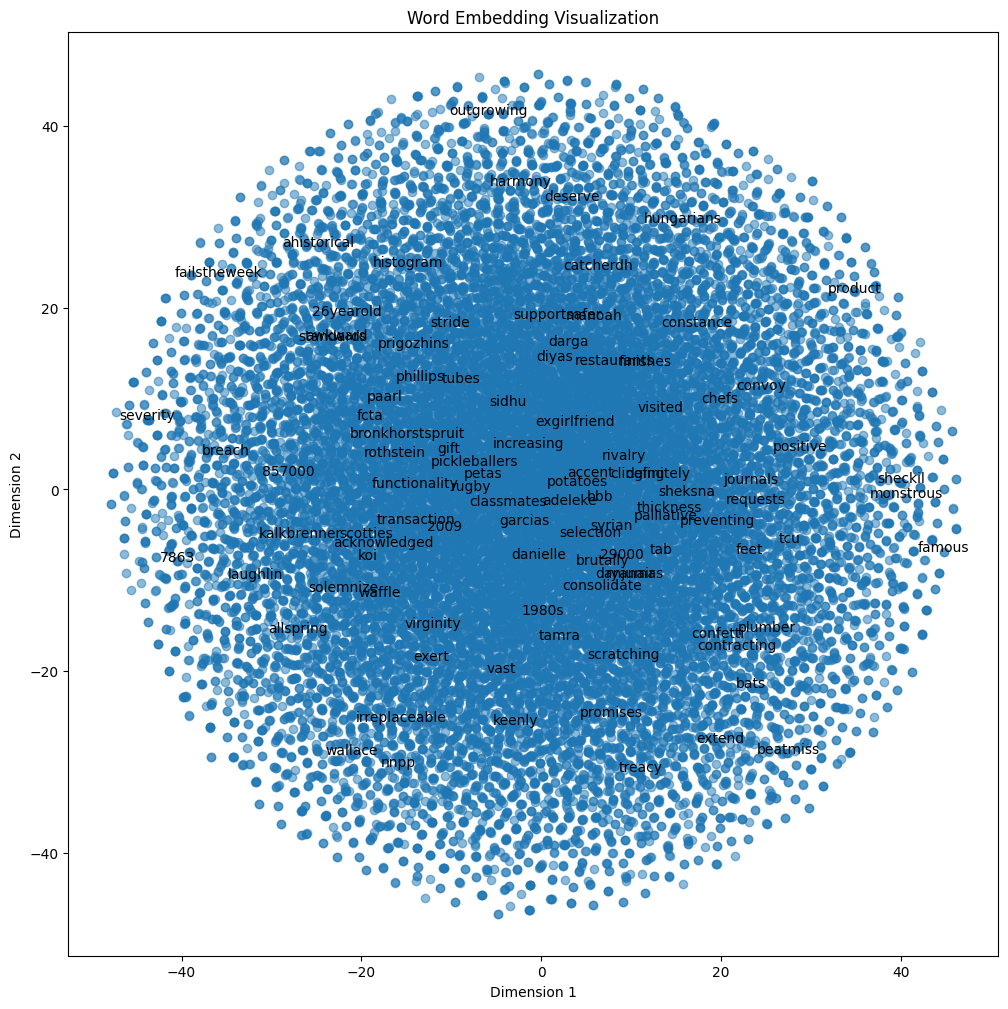

In [16]:
plt.figure(figsize=(12, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

# Annotate a subset of points
words_to_annotate = list(vocab)[:100]  # Adjust the number as needed
indices = [word_to_index[word] for word in words_to_annotate]

for idx in indices:
    plt.annotate(index_to_word[idx],
                 (embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
                 textcoords='offset points',
                 xytext=(0, 0),
                 ha='center')

plt.title('Word Embedding Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()